In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

# Introduction

Forecasting stock prices has been a well-known challenge for financial analysts. As part of our final project we aim to predict close prices of a time series 
representing daily close prices of a chosen stock. We will build a trading set up based on signals from the predictions. In our project we will train two models and assess their performance on the out-of-sample period.

# Literature Review

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models are widely used in trading strategies for their ability to model and forecast volatility in financial time series, capturing time-varying volatility clustering effectively. LSTM (Long Short-Term Memory) models, a type of recurrent neural network, excel in handling sequential data and capturing long-term dependencies, making them suitable for predicting stock prices and trends based on historical data. Recent studies highlight that while GARCH models are robust in volatility prediction, LSTM models often outperform in price prediction due to their non-linear processing capabilities. Combining both models can leverage GARCH's strength in volatility estimation and LSTM's prowess in trend prediction, potentially enhancing trading strategy performance.

# Data

Johnson & Johnson, a pharmaceutical company listed on the NYSE, was chosen for this project. It is a well established company contributing to the S&P500 index with no long-term directional movement in price over the last several years. It is a good candidate for testing the true power of autoregressive and machine learning models and displays high liquidity.

Instead of 6 years of close prices, 2 months of 5-minute prices were used. This translated to 2574 observations, more than the required 1512 (252 x 6).

In [29]:
jnj_raw = pd.read_csv('../jnj.us.txt')[["<DATE>", "<TIME>", "<OPEN>", "<CLOSE>"]].rename(columns={'<DATE>' :  'Date',
                                                                                                    '<TIME>':   'Time',
                                                                                                    '<OPEN>':   'Open',
                                                                                                    '<CLOSE>':  'Close'})
jnj_raw

,Date,Time,Open,Close
0,20240419,153000,146.150,144.8000
1,20240419,153500,144.800,145.4200
2,20240419,154000,145.440,145.6200
3,20240419,154500,145.660,145.9858
4,20240419,155000,145.975,146.1800
...,...,...,...,...
2569,20240607,213500,147.250,147.1700
2570,20240607,214000,147.170,147.0500
2571,20240607,214500,147.050,146.9300
2572,20240607,215000,146.930,147.1700


In [30]:
jnj_raw['DateStr'] = jnj_raw['Date'].astype(str)
jnj_raw['TimeStr'] = jnj_raw['Time'].astype(str)

jnj_raw['Date'] = jnj_raw['DateStr'].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:]}")
jnj_raw['Time'] = jnj_raw['TimeStr'].apply(lambda x: f"{x[:2]}:{x[2:4]}:{x[4:]}")

jnj_raw['Datetime'] = pd.to_datetime(jnj_raw['DateStr'] + ' ' + jnj_raw['TimeStr'])
jnj_raw = jnj_raw.drop(columns = ['Open'])
jnj_raw = jnj_raw.rename(columns = {'Close': 'JNJ'})

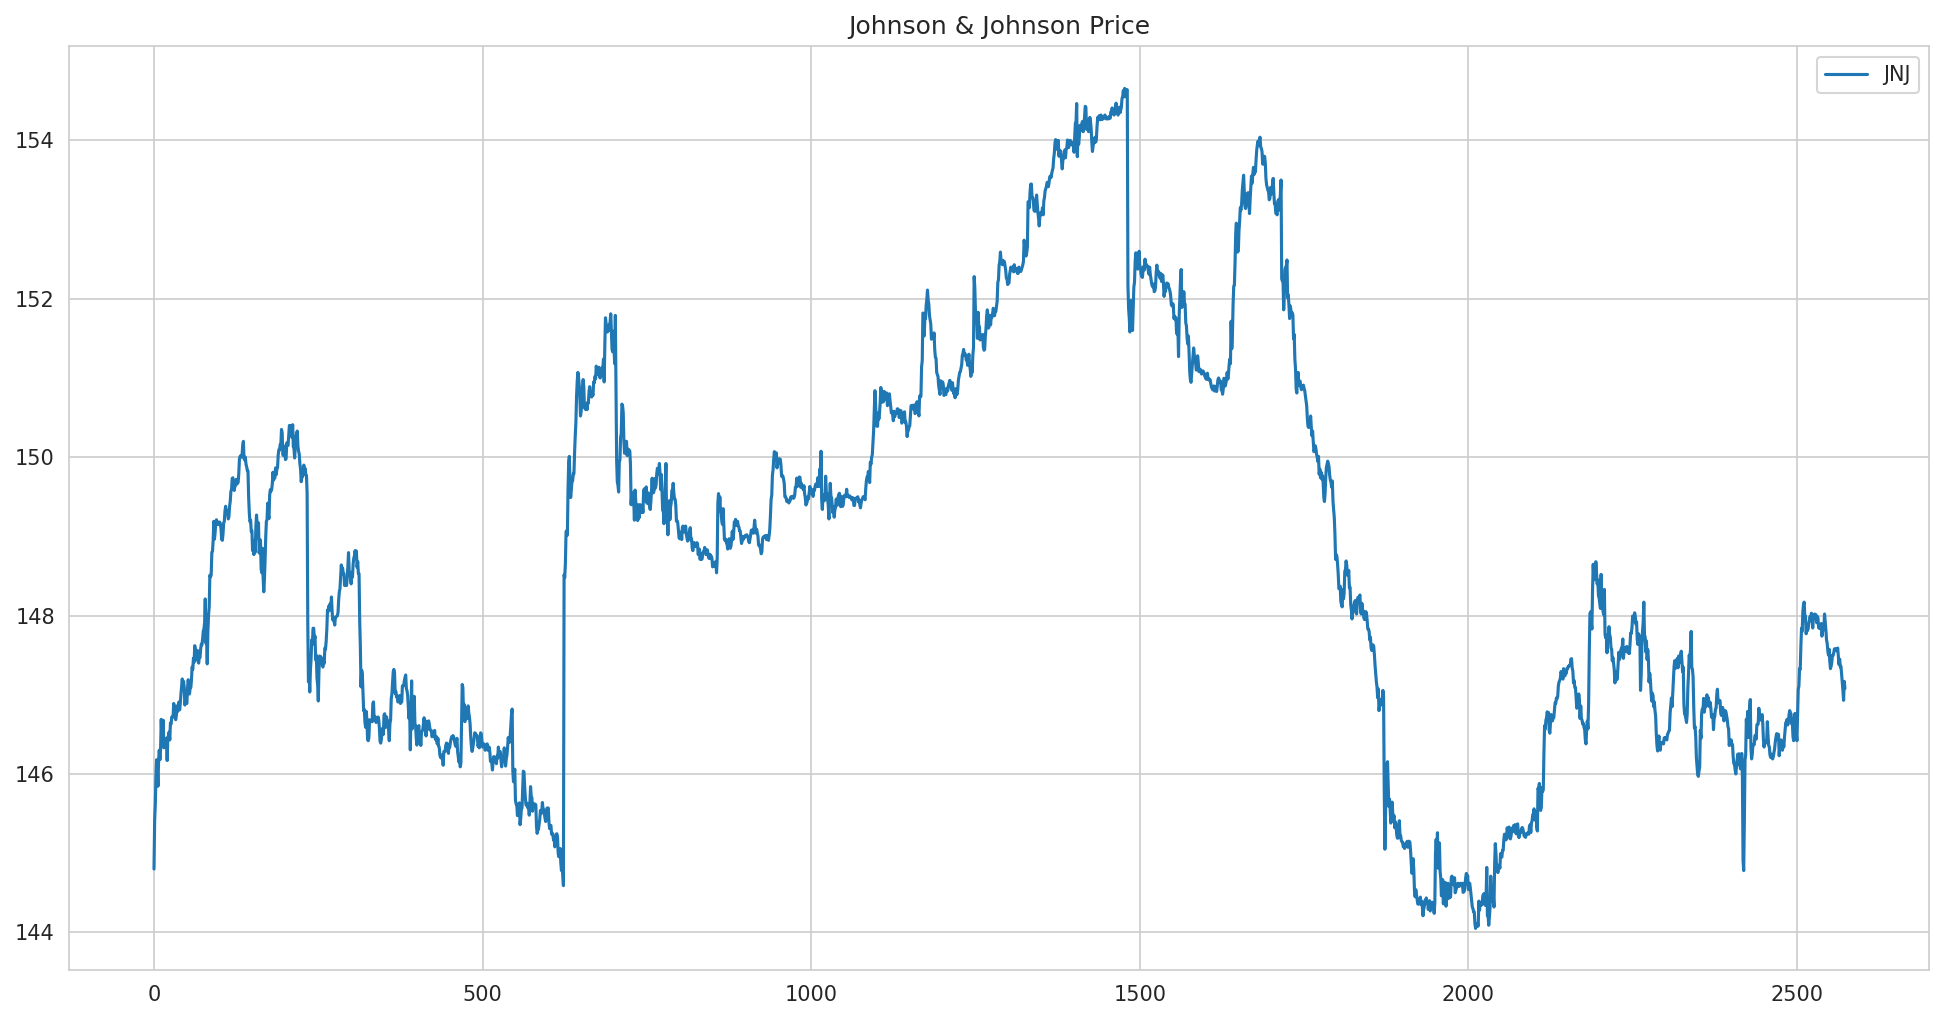

In [31]:
plt.figure(figsize=(16, 8), dpi=150) 

jnj_raw['JNJ'].plot(label='JNJ')
plt.title('Johnson & Johnson Price')
plt.legend()

In [32]:
returns = jnj_raw.fillna(method='ffill')
tickers = ['JNJ']

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

/tmp/ipykernel_7870/3228696151.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  returns = jnj_raw.fillna(method='ffill')


,Date,Time,JNJ,DateStr,TimeStr,Datetime,Ret_JNJ
1,2024-04-19,15:35:00,145.4200,20240419,153500,2024-04-19 15:35:00,0.004273
2,2024-04-19,15:40:00,145.6200,20240419,154000,2024-04-19 15:40:00,0.001374
3,2024-04-19,15:45:00,145.9858,20240419,154500,2024-04-19 15:45:00,0.002509
4,2024-04-19,15:50:00,146.1800,20240419,155000,2024-04-19 15:50:00,0.001329
5,2024-04-19,15:55:00,146.0800,20240419,155500,2024-04-19 15:55:00,-0.000684


# Methodology: Stats

In [33]:
class data_extraction:
    def __init__(self, data, asset):
        self.data = data
        self.asset = asset
        self.series = self.extract_series()

    def extract_series(self):
        return self.data[self.asset]

In [34]:
class analysis(data_extraction):
    def __init__(self, data, asset):
        data_extraction.__init__(self, data, asset)
        self.x = self.norm_dist()
    
    def acf_log_ret(self):
        plot_acf(self.series, lags=30, title='ACF Log Returns ' + self.asset)
        plt.show()
        
    def acf_sq_log_ret(self):
        plot_acf(self.series**2, lags=30, title='ACF Squared Log Returns ' + self.asset)
        plt.show()
        
    def describe(self):
        return describe(self.series)

    def norm_dist(self):
        mu, sigma = np.mean(self.series), np.std(self.series)
        x = np.random.normal(mu, sigma, 1000)
        x = pd.Series(x, name='Normal Distribution')
        return x
    
    def asset_hist_v_norm(self):
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax2.grid(False)
        ax1.hist(self.series, bins=30)
        g1 = sns.kdeplot(self.x, ax=ax2, color='r')
        g1.set(ylabel=None)
        g1.set(yticklabels=[])
        plt.title('Histogram vs Normal Distribution ' + self.asset);
    
    def asset_dist_v_norm(self):
        sns.set_style('whitegrid')
        series_norm = pd.concat([self.series, self.x], axis=1)
        sns.kdeplot(data=series_norm, bw_method=0.5)
        plt.title('Distribution vs Normal Distribution ' + self.asset);
    
    def arch_test(self):
        return het_arch(self.series)
    
    def arch_test_lag5(self):
        return het_arch(self.series, nlags=5)

In [35]:
analysis_jnj = analysis(returns, 'Ret_JNJ')

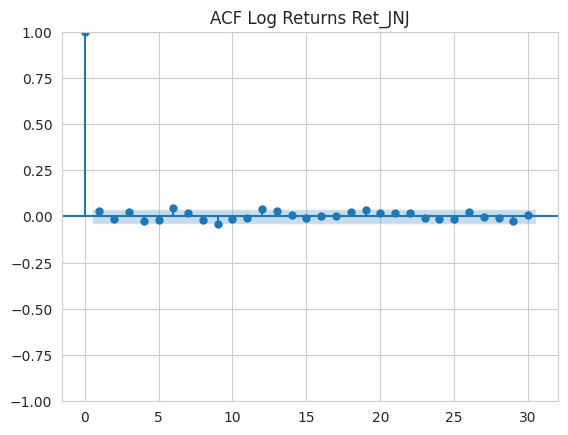

In [36]:
analysis_jnj.acf_log_ret()

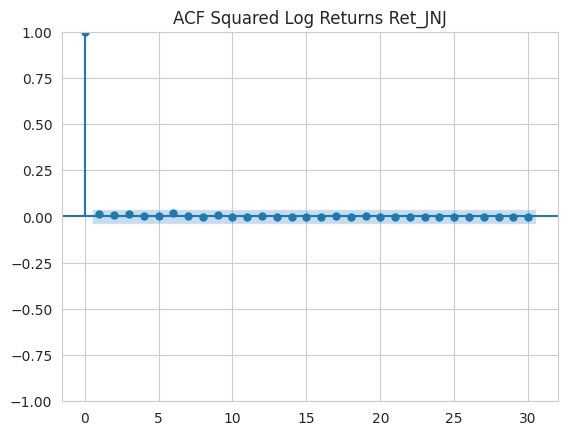

In [37]:
analysis_jnj.acf_sq_log_ret()

In [38]:
analysis_jnj.describe()

,Ret_JNJ
nobs,2.573000e+03
missing,0.000000e+00
mean,6.071969e-06
std_err,2.346566e-05
upper_ci,5.206382e-05
lower_ci,-3.991988e-05
std,1.190290e-03
iqr,8.986146e-04
iqr_normal,6.661440e-04
mad,6.749249e-04


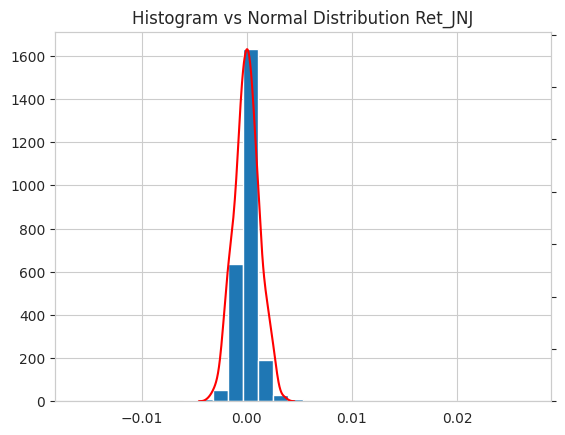

In [39]:
analysis_jnj.asset_hist_v_norm()

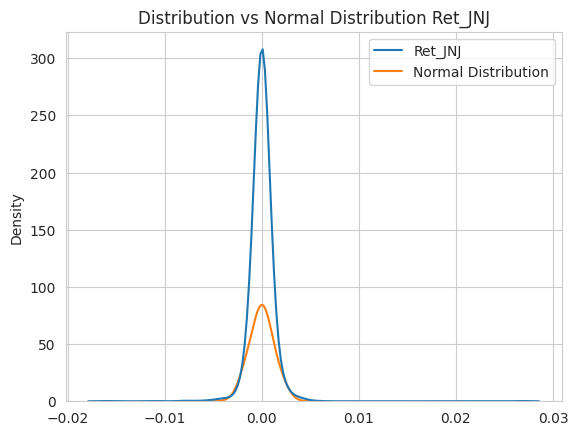

In [40]:
analysis_jnj.asset_dist_v_norm()

In [41]:
analysis_jnj.arch_test()

(2.0359732375622928,
 0.996056935957338,
 0.20288468123574321,
 0.9960952426299007)

In [42]:
analysis_jnj.arch_test_lag5()

(1.0866108654926752,
 0.9552819430220205,
 0.21690619162894148,
 0.9554283519085218)

# Methodology: Model

In [43]:
class garch_base(data_extraction):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags=0, o=0):
        data_extraction.__init__(self, data, asset)
        self.approach = approach
        self.proportion = proportion
        self.p = p
        self.o = o
        self.q = q
        self.mean = mean
        self.lags = lags
        self.train = self.series.iloc[:int(self.proportion*len(self.series))]
        self.test = self.series.iloc[int(self.proportion*len(self.series)):]
#         self.last_train_date = datetime.strftime(self.train.index[-1], '%Y-%m-%d')
        self.last_train_date = self.train.index[-1]
        self.res_garch = self.fit()
    
    def specs(self):
        return 'ar' + str(self.lags) + 'garch' + str(self.p) + str(self.q)

    def train_out(self):
        return self.train
    def fit(self):
        if self.approach == 'fixed':
            garch = arch.arch_model(self.train, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit()
        elif self.approach == 'roll1d':
            garch = arch.arch_model(self.series, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
            res_garch = garch.fit(last_obs=self.last_train_date)
            
        return res_garch
    
    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        plt.show()
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()

class garch(garch_base):
    def __init__(self, approach, proportion, p, q, mean, data, asset, lags=0, o=0):
        garch_base.__init__(self, approach, proportion, p, q, mean, data, asset, lags, o)
        self.forecast = self.forecast()
        self.exclusion_dates = self.get_exclusion_dates()
        self.forecast_mean_values = self.forecast_mean_values()
        self.forecast_std_values = self.forecast_std_values()
        self.forecast_vs_test = self.forecast_vs_test()

    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
#     def forecast_out(self):
#         return self.forecast
    
    def get_exclusion_dates(self):
#         return [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= self.last_train_date]
        return [i for i in self.forecast.mean.index.tolist() if i <= self.last_train_date]
    
    def forecast_mean_values(self):
        if self.approach == 'fixed':
            forecast_mean_values = self.forecast.mean.iloc[0]
        elif self.approach == 'roll1d':
            forecast_mean_values = self.forecast.mean.drop(self.exclusion_dates)
            forecast_mean_values = forecast_mean_values.iloc[:,0]
        
        return forecast_mean_values
    
    def forecast_mean(self):
#         forecast_mean = self.forecast.mean
#         forecast_mean.iloc[0].plot()
        self.forecast_mean_values.plot()

    def forecast_std_values(self):
        forecast_vol_raw = self.forecast.variance**0.5
        
        if self.approach == 'fixed':
            forecast_std_values = forecast_vol_raw.iloc[0]
        elif self.approach == 'roll1d':
            forecast_std_values = forecast_vol_raw.drop(self.exclusion_dates)
            forecast_std_values = forecast_std_values.iloc[:,0]
        
        return forecast_std_values
#         std3 = std2.transpose()
#         for i, col in enumerate(std3.columns):
#             std3[col] = std3[col].shift(i)
#         std3
#         std3.plot()
    
    def forecast_std(self):
#         forecast_stdev = self.forecast.variance**0.5
#         forecast_stdev.iloc[0].plot()
        self.forecast_std_values.plot()
    
    def forecast_vs_test(self):
#         if self.approach == 'fixed':
#             forecast_mean_values = self.forecast.mean.iloc[0].values
#         elif self.approach == 'roll1d':
#             exclusion_dates = [date for date in self.forecast.mean.index.strftime('%Y-%m-%d').tolist() if date <= last_train_date]
#             forecast_mean_values = self.forecast.mean.drop(exclusion_dates)
#             forecast_mean_values = forecast_mean_values.iloc[:,0].values

        forecast_mean_values = self.forecast_mean_values.values
        
        forecast_mean = pd.Series(forecast_mean_values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

#         forecast_vol_raw = self.forecast.variance**0.5
#         if self.approach == 'fixed':
#             forecast_std_values = forecast_vol_raw.iloc[0].values
#         elif self.approach == 'roll1d':
#             forecast_std_values = forecast_vol_raw.drop(exclusion_dates)
#             forecast_std_values = forecast_std_values.iloc[:,0].values
        
        forecast_std_values = self.forecast_std_values.values
        
        forecast_vs_test_condvol = pd.Series(forecast_std_values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()

In [44]:
ar1garch11 = garch('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_JNJ', 1)

/home/stanisz/Documents/programming/ATS_project/venv/lib64/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.43e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/stanisz/Documents/programming/ATS_project/venv/lib64/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.5425698815172735e+25
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4.4666679396213826e+19
Iteration:      3,   Func. Count:     38,   Neg. LLF: -8759.120334975538
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8759.12028147668
            Iterations: 3
            Function evaluations: 38
            Gradient evaluations: 3


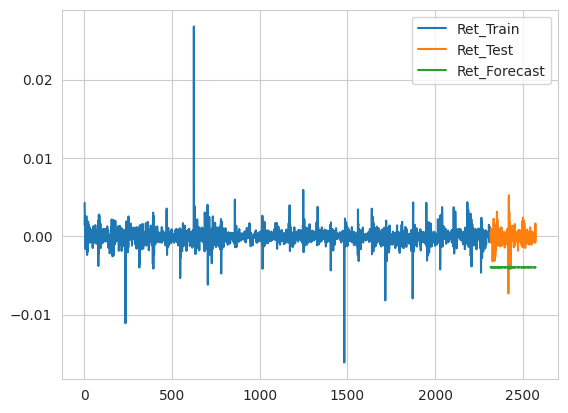

In [45]:
ar1garch11.forecast_vs_test_mean_plot()

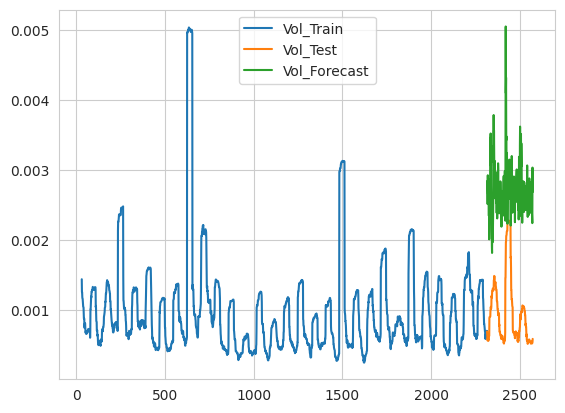

In [46]:
ar1garch11.forecast_vs_test_vol_plot()

# Methodology: Strategy

In [47]:
class strategy(garch):
    def __init__(self, approach, p, q, mean, data, asset, lags, o):
        garch.__init__(self, approach, p, q, mean, data, asset, lags, o)
        self.trade = self.build()
    
    def build(self):
        trade = self.forecast_vs_test
        
        last_train = trade.iloc[lambda x: x.index == self.last_train_date]
        last_vol_train = last_train['Vol_Train'][0]

        trade['direction'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Ret_Forecast'] > 0, 1, -1))
        trade['amplifier'] = np.where(trade['Ret_Train'].notna(), 0, np.where(trade['Vol_Forecast'] > last_vol_train, 2, 1))
        trade['position'] = trade['direction'] * trade['amplifier']
        trade['pnl_gross'] = trade['Ret_Test'] * trade['position']
        trade['pnl_gross_cum'] = trade['pnl_gross'].cumsum()
        trade['position_lag'] = trade['position'].shift(1)
        trade['cost'] = np.where(trade['position'] == trade['position_lag'], 0, 0.05)
        trade['pnl_net'] = trade['pnl_gross'] - trade['cost']
        trade['pnl_net_cum'] = trade['pnl_net'].cumsum()
        
        trade = trade.iloc[lambda x: x.index >= self.last_train_date]
        
        return trade
    
    def pos(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['direction'].plot(label='Direction')
        self.trade['amplifier'].plot(label='Amplifier')
        self.trade['position'].plot(label='Position')
        self.trade['cost'].plot(label='Cost')

        plt.title('Trading Positions ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def pnl_gross(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_gross'].plot(label='Gross P&L')
        self.trade['pnl_gross_cum'].plot(label='Cumulative Gross P&L')

        plt.title('Trading Gross P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
    
    def pnl_net(self):
        plt.figure(figsize=(16, 8), dpi=150) 

        self.trade['pnl_net'].plot(label='Net P&L')
        self.trade['pnl_net_cum'].plot(label='Cumulative Net P&L')

        plt.title('Trading Net P&L ' + self.asset + ' ' + self.specs())
        plt.legend()
        
    def sr(self):
        sr_gross = 252 ** 0.5 * np.mean(self.trade['pnl_gross']) / np.std(self.trade['pnl_gross'])
        sr_net = 252 ** 0.5 * np.mean(self.trade['pnl_net']) / np.std(self.trade['pnl_net'])
        
        return pd.DataFrame({'Metric': ['SR Gross', 'SR Net'], 'Value': [sr_gross, sr_net]})

In [48]:
ar1garch11_strat = strategy('roll1d', 0.9, 1, 1, 'AR', returns, 'Ret_DCOILWTICO', 1)

KeyError: 'Ret_DCOILWTICO'

# Project

We will be trying to perform univariate prediction on the time series of stock prices of Johnson & Johnson.

## Loading Libraries

In [137]:
# Shared processing imports start here...
import numpy as np                  # General purpose math
import pandas as pd                 # Dataframes
import matplotlib.pyplot as plt     # Simple plotting
# End of shared processing imports.

# LSTM processing imports start here...
import tensorflow as tf                                 # LSTM support
from tensorflow.keras.layers import LSTM                # LSTM model definition
from tensorflow.keras.models import Sequential          # Sequential LSTM layer
from tensorflow.keras.layers import Dense               # Dense LSTM layer
from sklearn.preprocessing import MinMaxScaler          # Transforming the observations to a specific range
from sklearn.model_selection import train_test_split    # Enabling out-of-sample validation
from sklearn.metrics import mean_squared_error          # Model evaluation
import quantstats as qs                                 # calculating ratios
# End of LSTM processing imports.

## Loading Input Data

In [158]:
jnj_close = pd.read_csv('../jnj.us.txt')[["<DATE>", "<TIME>", "<OPEN>", "<CLOSE>"]].rename(columns={'<DATE>' :  'Date',
                                                                                                    '<TIME>':   'Time',
                                                                                                    '<OPEN>':   'Open',
                                                                                                    '<CLOSE>':  'Close'})
jnj_close.head()

,Date,Time,Open,Close
0,20240419,153000,146.150,144.8000
1,20240419,153500,144.800,145.4200
2,20240419,154000,145.440,145.6200
3,20240419,154500,145.660,145.9858
4,20240419,155000,145.975,146.1800


### Preprocessing Raw Data

The date and time information is split between two columns. We will create a single column unifying the two to allow us to later construct a timestamp.

In [159]:
jnj_close['Datetime String'] = jnj_close.Date.map(str) + " " + jnj_close.Time.map(str)
jnj_close.head()

,Date,Time,Open,Close,Datetime String
0,20240419,153000,146.150,144.8000,20240419 153000
1,20240419,153500,144.800,145.4200,20240419 153500
2,20240419,154000,145.440,145.6200,20240419 154000
3,20240419,154500,145.660,145.9858,20240419 154500
4,20240419,155000,145.975,146.1800,20240419 155000


In [160]:
# Redefine the column by parsing contents as pandas datetime:
jnj_close['Datetime'] = pd.to_datetime(jnj_close['Datetime String'], format='%Y%m%d %H%M%S')  
# Set the index of the dataframe -- each observation is unique in time. That should help plotting:
jnj_close = jnj_close.set_index('Datetime').drop(columns=['Datetime String', 'Date', 'Time']) 

jnj_close.head()

,Open,Close
Datetime,,
2024-04-19 15:30:00,146.150,144.8000
2024-04-19 15:35:00,144.800,145.4200
2024-04-19 15:40:00,145.440,145.6200
2024-04-19 15:45:00,145.660,145.9858
2024-04-19 15:50:00,145.975,146.1800


One last thing remaining: the 'Close' variable is the target we want to predict. Prediction models we build will have to operate on lagged open/close variables to ensure we eliminate the **look-ahead bias**.

In [182]:
jnj_close['Open Lag']   = jnj_close['Open'].shift(6)
jnj_close['Close Lag']  = jnj_close['Close'].shift(6)
jnj_close.head(10)

,Open,Close,Open Lag,Close Lag
Datetime,,,,
2024-04-19 16:00:00,0.209603,0.169242,NaN,NaN
2024-04-19 16:05:00,0.185596,0.199885,NaN,NaN
2024-04-19 16:10:00,0.216990,0.212142,NaN,NaN
2024-04-19 16:15:00,0.230840,0.200828,NaN,NaN
2024-04-19 16:20:00,0.218375,0.213556,NaN,NaN
2024-04-19 16:25:00,0.231764,0.248913,NaN,NaN
2024-04-19 16:30:00,0.264081,0.224871,0.209603,0.169242
2024-04-19 16:35:00,0.241921,0.237599,0.185596,0.199885
2024-04-19 16:40:00,0.253001,0.247810,0.216990,0.212142


In [183]:
jnj_close = jnj_close.dropna()

### Useful Global Variables

We will define global variables to be used across both trading strategies. They will be initialized with capital letters.

In [216]:
TRANSACTION_COSTS = 0.01

## Training LSTM

We will start the model building process by affixing the random seed for reproducibility.

In [163]:
tf.random.set_seed(7)

### Intermediate Data Preprocessing

LSTMs are sensitive to input data scale. We need to normalize our dataframe values before fitting the model to ensure best performance. 

In [164]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling transformation returns raw numbers instead of a dataframe -- convert to dataframe on-the-fly:
jnj_close = pd.DataFrame(scaler.fit_transform(jnj_close), index=jnj_close.index, columns=jnj_close.columns)
jnj_close.head()

,Open,Close,Open Lag,Close Lag
Datetime,,,,
2024-04-19 16:00:00,0.209603,0.169242,0.215143,0.070714
2024-04-19 16:05:00,0.185596,0.199885,0.090489,0.129171
2024-04-19 16:10:00,0.216990,0.212142,0.149584,0.148028
2024-04-19 16:15:00,0.230840,0.200828,0.169898,0.182518
2024-04-19 16:20:00,0.218375,0.213556,0.198984,0.200828


### Train-test Split

The model needs to be validated on a portion of the dataset which was not used for training. We perform a "train-test" split.
Additionally, we will focus on close price prediction only (lagged open values will remain as features).

In [165]:
X = jnj_close[['Open Lag', 'Close Lag']] # Notice how the 'Open' column is implicitly dropped, unused.
y = jnj_close[['Close']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train.head()

,Open Lag,Close Lag
Datetime,,
2024-05-20 16:30:00,0.750693,0.730089
2024-05-22 17:35:00,0.881810,0.887225
2024-05-22 21:10:00,0.885503,0.874025
2024-06-04 21:50:00,0.264543,0.245142
2024-05-24 20:35:00,0.369344,0.353570


### Reshaping Inputs

LSTMs require 3-dimensional inputs in the form of [samples, timesteps, features]. We will reshape inputs.

In [166]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

### Defining the Model

An LSTM model is defined with multiple intermediate Dense layers. This increases both model accuracy and overall training time.

In [187]:
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(1,2)))
model.add(Dense(2))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

### Model Fitting

In [188]:
fitting_history = model.fit(X_train, y_train, epochs=15, batch_size=3, verbose=2)

Epoch 1/15
813/813 - 4s - 4ms/step - loss: 0.0811
Epoch 2/15
813/813 - 2s - 2ms/step - loss: 0.0155
Epoch 3/15
813/813 - 2s - 2ms/step - loss: 0.0024
Epoch 4/15
813/813 - 2s - 2ms/step - loss: 0.0020
Epoch 5/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 6/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 7/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 8/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 9/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 10/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 11/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 12/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 13/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 14/15
813/813 - 2s - 2ms/step - loss: 0.0019
Epoch 15/15
813/813 - 2s - 2ms/step - loss: 0.0019


### Plotting the History of Model Fitting

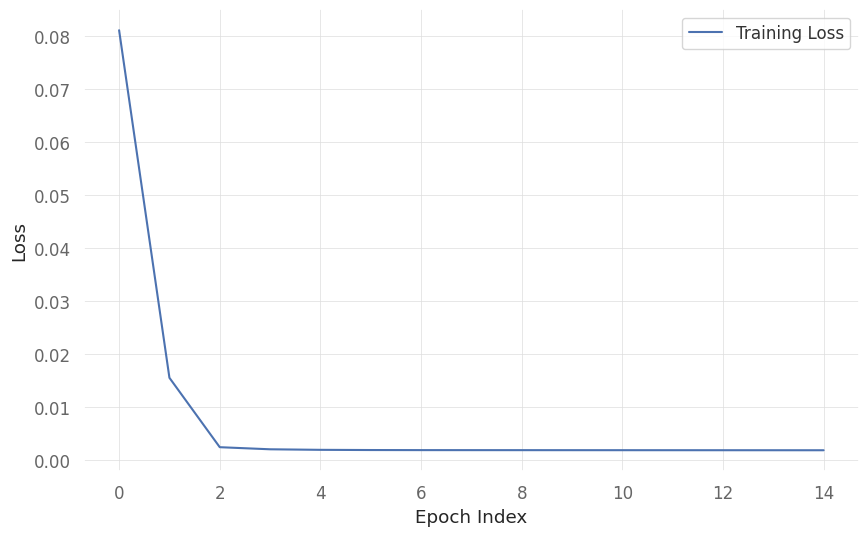

In [189]:
_, ax = plt.subplots()
ax.plot(fitting_history.history['loss'], label='Training Loss')
ax.set_xlabel('Epoch Index')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

We can see that the loss quickly diminishes and remains constant after the initial epoch. 

### Making LSTM Predictions

In [191]:
testPredict = model.predict(X_test)[:,1]
testPredict = testPredict.reshape(len(testPredict), 1)

trainPredict = model.predict(X_train)[:,1]
trainPredict = trainPredict.reshape(len(trainPredict), 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [192]:
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.4f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.4f RMSE' % (testScore))

Train Score: 0.0420 RMSE
Test Score: 0.0392 RMSE


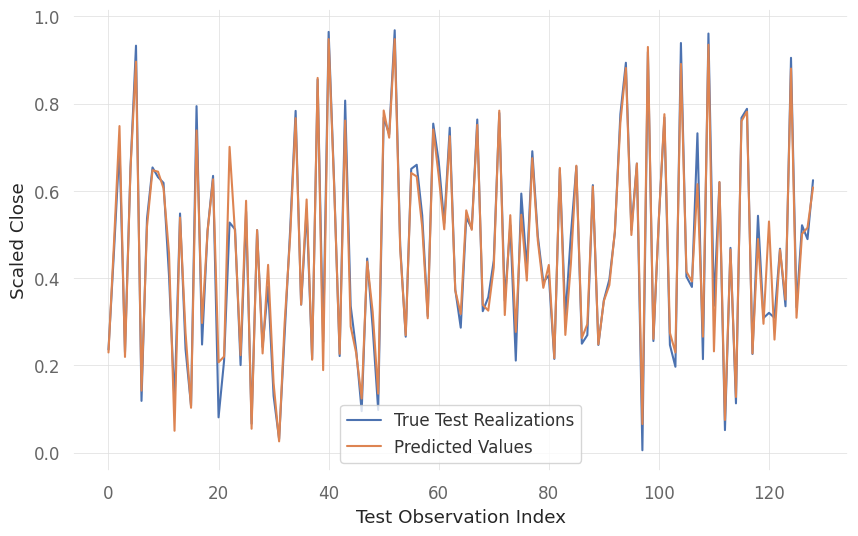

In [193]:
_, ax = plt.subplots()
ax.plot(y_test.values, label='True Test Realizations')
ax.plot(testPredict, label='Predicted Values')
ax.set_xlabel('Test Observation Index')
ax.set_ylabel('Scaled Close')
plt.legend()
plt.show()

### Training Results

As seen on the above figure, we get absolutely **amazing** predictions of the scaled close price. The test score is only *slightly* worse than the train score (as expected), which means that the procedure does not overfit the model. 

### Defining a Trading Strategy

A simple training strategy is long when the model predicts a positive return. It will do nothing if the predicted return is negative to limit trading frequency.

First, the test sample data is arranged into a data frame, because LSTM forced data into numpy arrays above. The below daraframe still operates on scaled (to [0,1]) values.

In [194]:
lstm_strategy = pd.DataFrame(data=[y_test.values.T[0], testPredict.T[0]]).transpose()
lstm_strategy.columns = columns=['True', 'Predicted']
lstm_strategy.head()

,True,Predicted
0,0.236232,0.229758
1,0.461055,0.480758
2,0.701483,0.748710
3,0.230056,0.219560
4,0.653398,0.650337


Let's invert the scaling applied on the dataset to get the actual values of the close price:

In [195]:
predicted = testPredict.T[0].reshape(-1, 1)
predicted = np.c_[ predicted, predicted, predicted, predicted ] # The original transform had 4 features, we only need one. But we need to match the shape...  
predicted = scaler.inverse_transform(predicted)[:,1]

actual = y_test.values.T[0].reshape(-1, 1)
actual = np.c_[ actual, actual, actual, actual ] 
actual = scaler.inverse_transform(actual)[:,1]

We can see that after the inversion, the prices are back to their original data range:

In [217]:
lstm_strategy = pd.DataFrame(data=[actual, predicted]).transpose()
lstm_strategy.columns = columns=['True', 'Predicted']
lstm_strategy.head()

,True,Predicted
0,146.5555,146.486832
1,148.9400,149.148972
2,151.4900,151.990891
3,146.4900,146.378677
4,150.9800,150.947540


Then, predicted and true returns on the out-of-sample test period are calculated. 

In [218]:
lstm_strategy['Predicted Return'] = (lstm_strategy['Predicted'] - lstm_strategy['Predicted'].shift(1)).shift(-1)
lstm_strategy['True Return'] = (lstm_strategy['True'] - lstm_strategy['True'].shift(1)).shift(-1)

lstm_strategy = lstm_strategy.dropna()
lstm_strategy.head()

,True,Predicted,Predicted Return,True Return
0,146.5555,146.486832,2.662140,2.3845
1,148.9400,149.148972,2.841919,2.5500
2,151.4900,151.990891,-5.612213,-5.0000
3,146.4900,146.378677,4.568863,4.4900
4,150.9800,150.947540,2.609772,2.9650


Next, signal is defined to equal 1 only if predicted one-day return is positive. The strategy doesn't trade otherwise.

In [219]:
lstm_strategy = lstm_strategy.assign(signal = lambda row: row['Predicted Return'] > 0)
lstm_strategy.head()

,True,Predicted,Predicted Return,True Return,signal
0,146.5555,146.486832,2.662140,2.3845,True
1,148.9400,149.148972,2.841919,2.5500,True
2,151.4900,151.990891,-5.612213,-5.0000,False
3,146.4900,146.378677,4.568863,4.4900,True
4,150.9800,150.947540,2.609772,2.9650,True


Now that the signal is defined, strategy returns are defined to equal the actual returns obtained in the market that time **less transaction costs** defined above. Please note -- the time index here represents 5-minute observations. The evaluation period is therefore short.

In [220]:
lstm_strategy = lstm_strategy.assign(strategy_gross_returns = lambda row: row['signal'] * row['True Return'])
lstm_strategy['Did Position Change'] = (lstm_strategy['signal'].shift(1) == False) & (lstm_strategy['signal'] == True) # Am I assuming a new long position?
lstm_strategy = lstm_strategy.assign(strategy_net_returns = lambda row: row['strategy_gross_returns'] - row['Did Position Change'] * TRANSACTION_COSTS * row['True'])
lstm_strategy['Cumulative Gross Returns'] = lstm_strategy.cumsum()['strategy_gross_returns']
lstm_strategy['Cumulative Net Returns'] = lstm_strategy.cumsum()['strategy_net_returns']
lstm_strategy.head(10)

,True,Predicted,Predicted Return,True Return,signal,strategy_gross_returns,Did Position Change,strategy_net_returns,Cumulative Gross Returns,Cumulative Net Returns
0,146.5555,146.486832,2.662140,2.3845,True,2.3845,False,2.3845,2.3845,2.3845
1,148.9400,149.148972,2.841919,2.5500,True,2.5500,False,2.5500,4.9345,4.9345
2,151.4900,151.990891,-5.612213,-5.0000,False,-0.0000,False,-0.0000,4.9345,4.9345
3,146.4900,146.378677,4.568863,4.4900,True,4.4900,True,3.0251,9.4245,7.9596
4,150.9800,150.947540,2.609772,2.9650,True,2.9650,False,2.9650,12.3895,10.9246
5,153.9450,153.557312,-7.997772,-8.6350,False,-0.0000,False,-0.0000,12.3895,10.9246
6,145.3100,145.559540,3.991394,4.4300,True,4.4300,True,2.9769,16.8195,13.9015
7,149.7400,149.550934,1.367157,1.2450,True,1.2450,False,1.2450,18.0645,15.1465
8,150.9850,150.918091,-0.036713,-0.2350,False,-0.0000,False,-0.0000,18.0645,15.1465
9,150.7500,150.881378,-0.401657,-0.1400,False,-0.0000,False,-0.0000,18.0645,15.1465


### Plotting Results

Strategy results are plotted agains true and predicted returns. They include transaction costs defined above.

<Axes: >

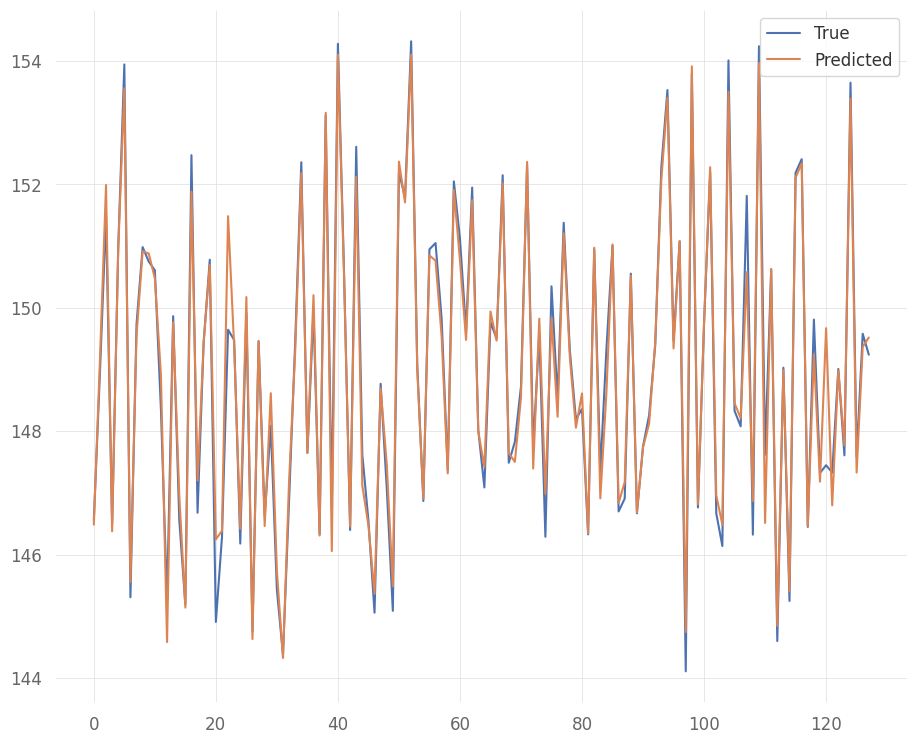

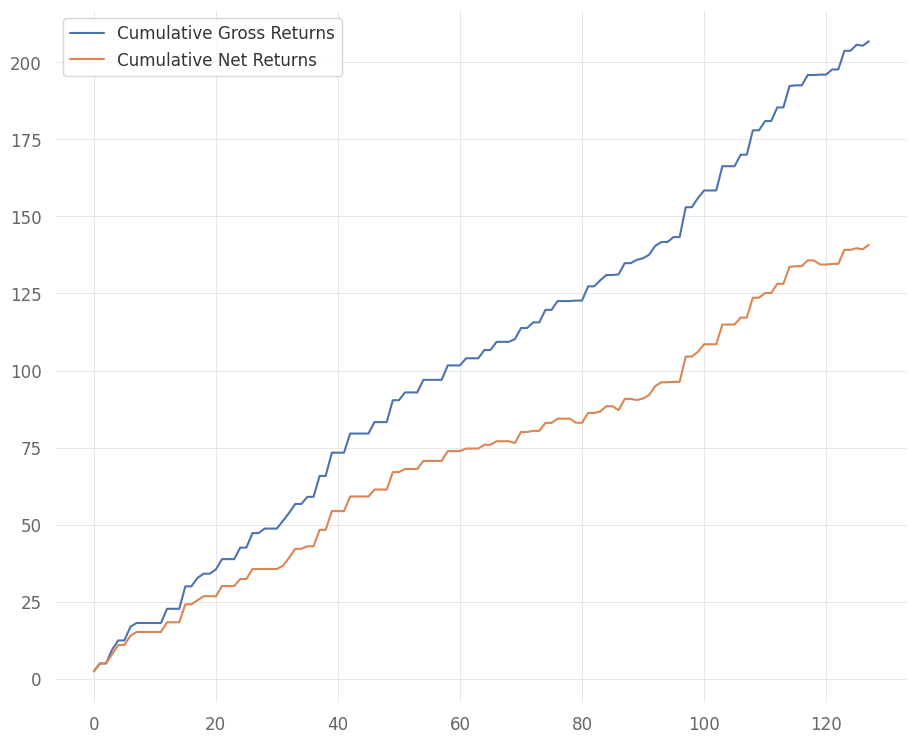

In [221]:
lstm_strategy[['True', 'Predicted']].plot(figsize=(11,9))
lstm_strategy[['Cumulative Gross Returns', 'Cumulative Net Returns']].plot(figsize=(11,9))

### Performance Measures

The LSTM model is assessed using the total Sharpe Ratio on the out-of-sample test period. Simple statistics on the number of performed trades are calculated.

In [222]:
lstm_number_of_trades = lstm_strategy.cumsum()['signal'].iloc[-1]
lstm_proportion_of_trades = lstm_number_of_trades / len(lstm_strategy)
print(f"LSTM model made {lstm_number_of_trades} trades, it traded {lstm_proportion_of_trades:.{2}}% of times on average.")

LSTM model made 64 trades, it traded 0.5% of times on average.


In [225]:
lstm_sharpe = qs.stats.sharpe(lstm_strategy[['Cumulative Net Returns']])[0]
print(f"LSTM model total Net Sharpe Ratio is equal to {lstm_sharpe:.{3}}")

LSTM model total Net Sharpe Ratio is equal to 4.92


/tmp/ipykernel_7870/3507800921.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lstm_sharpe = qs.stats.sharpe(lstm_strategy[['Cumulative Net Returns']])[0]


As predicted, the Sharpe ratio is extremely high. Even including transaction costs, the strategy generates profits steadily and, because it trades only long, the variance of cumulative returns is very low. 

# Results

# Conclusion

The LSTM model performed very well with an impressive Sharpe ratio. We believe the high result is attributed to the specification of the LSTM model, which is capturing short relationships in time very well. This is also when the diminishing gradients problem does not impact the prediction adversely. Additionally, the forecasting period of our stock is very stable and behaves like a mean reverting process. Such a relationship is easily discovered by a model with a dense neural layer, as it's effectively partially reduced to a scalar multiplication by -1. We believe the model results could have been much worse during a more volatile period on the market. Nonetheless, the model results are impressive, we strongly believe it could be selected for a calmer-market strategies.

# References

 - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
 - https://stackoverflow.com/questions/8486294/how-do-i-add-an-extra-column-to-a-numpy-array
 - https://pypi.org/project/QuantStats/
 - https://stackoverflow.com/questions/57216718/how-to-inverse-transform-the-predicted-values-in-a-multivariate-time-series-lstm
 - https://en.wikipedia.org/wiki/Long_short-term_memory

# Distribution of Work

Distribution of work matches our initial division of work from the project proposal. In general:

Adam:
 - Definition of classes used in the first trading strategy
 - Descriptive statistics of the dataset 
 - Implementation and testing of GARCH
 - Evalutation of the first model

Maciek:
 - Reading and preparing the time series
 - Implementation and testing of the LSTM model
 - Evaluation of LSTM, plotting results and strategy returns 